In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud               
import re
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn

from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import pickle
from sklearn.externals import joblib

# Stack Overflow: Tag Prediction

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<h1>Machine Learning problem </h1>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h1> Machine Learning Models </h1>

<h3>  Featurizing data with TfIdf vectorizer </h3>

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False,
                             ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:18.075098


In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


<h3>  OneVsRest Classifier with SGDClassifier using TFIDF  </h3>

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log',
                                               alpha=0.00001,
                                               penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23625
Hamming loss  0.00278104
Micro-average quality numbers
Precision: 0.7216, Recall: 0.3256, F1-measure: 0.4488
Macro-average quality numbers
Precision: 0.5490, Recall: 0.2571, F1-measure: 0.3342
             precision    recall  f1-score   support

          0       0.94      0.64      0.76      5519
          1       0.68      0.26      0.38      8190
          2       0.81      0.38      0.52      6529
          3       0.81      0.43      0.56      3231
          4       0.81      0.41      0.54      6430
          5       0.82      0.34      0.48      2879
          6       0.87      0.49      0.63      5086
          7       0.88      0.54      0.67      4533
          8       0.61      0.13      0.21      3000
          9       0.81      0.53      0.64      2765
         10       0.59      0.17      0.26      3051
         11       0.70      0.33      0.45      3009
         12       0.65      0.25      0.36      2630
         13       0.71      0.23      0.35   

In [ ]:

joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

['lr_with_more_title_weight.pkl']

##### ASSIGNMENT

In [ ]:
<ol>
    <li>  bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li>  OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

## Featurizing Using Bag of Words  

In [ ]:
alpha=[10**-3,10**-2,10**-1]

In [ ]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000,  \
                             tokenizer = lambda x: x.split(),  ngram_range=(1,4))


In [ ]:
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:24.935906


In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


#####  Dump and load train and test data into joblib

In [ ]:
joblib.dump(x_train_multilabel, 'x_train_BOW.pkl') 
joblib.dump(x_test_multilabel, 'x_test_BOW.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [ ]:
x_train_multilabel = joblib.load('x_train_BOW.pkl')
y_train = joblib.load('y_train.pkl')


In [ ]:
x_test_multilabel = joblib.load('x_test_BOW.pkl')
y_test = joblib.load('y_test.pkl')

# OneVsRestClassifier with  Logistic regression 
#### (alpha tuning using Gridsearch)

## OneVsRestClassifier with SGDClassifier( penalty=l2, loss=log )==> {Logistic regression}


0.001
{'estimator__alpha': [0.001], 'estimator__loss': ['log'], 'estimator__penalty': ['l2']}
Gridsearchcv
fit model
0.01
{'estimator__alpha': [0.01], 'estimator__loss': ['log'], 'estimator__penalty': ['l2']}
Gridsearchcv
fit model
0.1
{'estimator__alpha': [0.1], 'estimator__loss': ['log'], 'estimator__penalty': ['l2']}
Gridsearchcv
fit model

 The optimal value of alpha with penalty=l1 and loss= log is 0.


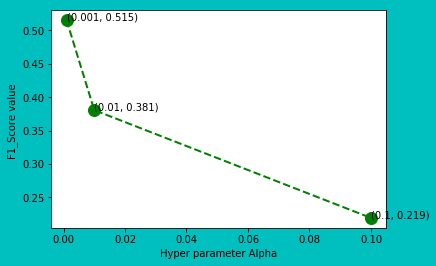

Time taken to run this cell : 1:59:14.455889


In [ ]:
start = datetime.now()
import warnings
warnings.filterwarnings('ignore')

# hp1={'estimator__C':alpha}

cv_scores = []
for i in alpha: 
    print(i)
    hp1={'estimator__alpha':[i],
         'estimator__loss':['log'],
         'estimator__penalty':['l2']}
    print(hp1)
    classifier = OneVsRestClassifier(SGDClassifier())

    model11 =GridSearchCV(classifier,hp1,
                          cv=3, scoring='f1_micro',n_jobs=-1)
    print("Gridsearchcv")
    best_model1=model11.fit(x_train_multilabel, y_train)
    print('fit model')
    Train_model_score=best_model1.score(x_train_multilabel, 
                                        y_train)
#print("best_model1")
    cv_scores.append(Train_model_score.mean())

fscore = [x for x in cv_scores]

# determining best alpha
optimal_alpha21 = alpha[fscore.index(max(fscore))]
print('\n The optimal value of alpha with penalty=l2 and loss= log is %d.' % optimal_alpha21)

# Plots
fig4 = plt.figure( facecolor='c', edgecolor='k')
plt.plot(alpha, fscore,color='green', marker='o', linestyle='dashed',
linewidth=2, markersize=12)

for xy in zip(alpha, np.round(fscore,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyper parameter Alpha')
plt.ylabel('F1_Score value ')
plt.show()

print("Time taken to run this cell :", datetime.now() - start)


In [ ]:
print(optimal_alpha21)

0.001


In [ ]:
start = datetime.now()
best_model1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=optimal_alpha21,
                                               penalty='l2'), n_jobs=-1)
best_model1.fit(x_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=-1)

In [ ]:
joblib.dump(best_model1, 'best_model1_LR.pkl')

['best_model1_LR.pkl']

In [ ]:
best_model1=joblib.load('best_model1_LR.pkl')

In [ ]:
predictions = best_model1.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-averasge quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions)) #printing classification report for all 500 labels
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2117
Hamming loss  0.00296836
Micro-averasge quality numbers
Precision: 0.6491, Recall: 0.3179, F1-measure: 0.4268
Macro-average quality numbers
Precision: 0.4948, Recall: 0.2353, F1-measure: 0.3058
             precision    recall  f1-score   support

          0       0.95      0.64      0.76      5519
          1       0.68      0.27      0.39      8190
          2       0.80      0.37      0.51      6529
          3       0.82      0.42      0.55      3231
          4       0.80      0.43      0.56      6430
          5       0.80      0.35      0.49      2879
          6       0.88      0.47      0.62      5086
          7       0.87      0.56      0.68      4533
          8       0.60      0.14      0.23      3000
          9       0.81      0.57      0.67      2765
         10       0.59      0.21      0.31      3051
         11       0.71      0.33      0.45      3009
         12       0.63      0.27      0.38      2630
         13       0.73      0.27      0.39   

## OneVsRestClassifier with Logistic regression( penalty=l1 ) 


0.001
{'estimator__alpha': [0.001], 'estimator__loss': ['log'], 'estimator__penalty': ['l1']}
Gridsearchcv
fit model
0.01
{'estimator__alpha': [0.01], 'estimator__loss': ['log'], 'estimator__penalty': ['l1']}
Gridsearchcv
fit model
0.1
{'estimator__alpha': [0.1], 'estimator__loss': ['log'], 'estimator__penalty': ['l1']}
Gridsearchcv
fit model

 The optimal value of alpha with penalty=l1 and loss= log is 0.


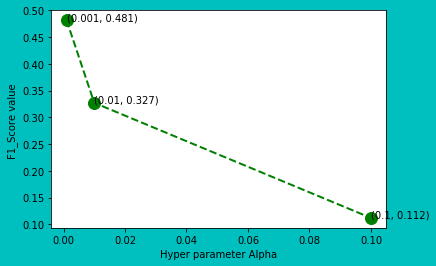

Time taken to run this cell : 2:56:17.727412


In [ ]:
start = datetime.now()
import warnings
warnings.filterwarnings('ignore')

# hp1={'estimator__C':alpha}

cv_scores = []
for i in alpha: 
    print(i)
    hp1={'estimator__alpha':[i],
         'estimator__loss':['log'],
         'estimator__penalty':['l1']}
    print(hp1)
    classifier = OneVsRestClassifier(SGDClassifier())

    model11 =GridSearchCV(classifier,hp1,
                          cv=3, scoring='f1_micro',n_jobs=-1)
    print("Gridsearchcv")
    best_model1=model11.fit(x_train_multilabel, y_train)
    print('fit model')
    Train_model_score=best_model1.score(x_train_multilabel, 
                                        y_train)
#print("best_model1")
    cv_scores.append(Train_model_score.mean())

fscore = [x for x in cv_scores]

# determining best alpha
optimal_alpha22 = alpha[fscore.index(max(fscore))]
print('\n The optimal value of alpha with penalty=l1 and loss= log is %d.' % optimal_alpha22)

# Plots
fig4 = plt.figure( facecolor='c', edgecolor='k')
plt.plot(alpha, fscore,color='green', marker='o', linestyle='dashed',
linewidth=2, markersize=12)

for xy in zip(alpha, np.round(fscore,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyper parameter Alpha')
plt.ylabel('F1_Score value ')
plt.show()

print("Time taken to run this cell :", datetime.now() - start)


In [ ]:
start = datetime.now()
best_model2 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=optimal_alpha22,
                                               penalty='l1'), n_jobs=-1)
best_model2.fit(x_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=-1)

In [ ]:
joblib.dump(best_model2, 'best_model2_LR.pkl')

['best_model2_LR.pkl']

In [ ]:
best_model2=joblib.load('best_model2_LR.pkl')

## Logistic regression with l1 penalty

In [ ]:
start = datetime.now()
#classifier = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
#classifier.fit(x_train_multilabel, y_train)
predictions = best_model2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1879
Hamming loss  0.00319694
Micro-average quality numbers
Precision: 0.5718, Recall: 0.3201, F1-measure: 0.4104
Macro-average quality numbers
Precision: 0.4113, Recall: 0.2385, F1-measure: 0.2830
             precision    recall  f1-score   support

          0       0.68      0.68      0.68      5519
          1       0.57      0.20      0.29      8190
          2       0.75      0.33      0.46      6529
          3       0.76      0.40      0.52      3231
          4       0.70      0.42      0.53      6430
          5       0.62      0.39      0.48      2879
          6       0.72      0.55      0.62      5086
          7       0.83      0.60      0.69      4533
          8       0.48      0.14      0.22      3000
          9       0.75      0.48      0.59      2765
         10       0.57      0.14      0.23      3051
         11       0.66      0.37      0.48      3009
         12       0.61      0.22      0.32      2630
         13       0.54      0.14      0.22    

##  OneVsRestClassifier with Linear-SVM (SGDClassifier with loss-hinge)  

0.001
{'estimator__alpha': [0.001], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l1']}
Gridsearchcv
fit model
0.01
{'estimator__alpha': [0.01], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l1']}
Gridsearchcv
fit model
0.1
{'estimator__alpha': [0.1], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l1']}
Gridsearchcv
fit model

 The optimal value of alpha with penalty=l1 and loss= log is 0.


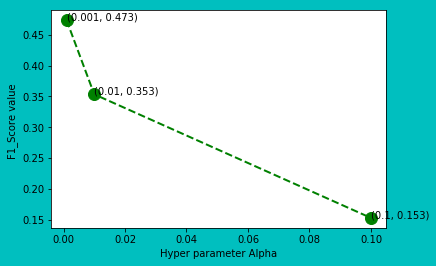

Time taken to run this cell : 2:18:49.138029


In [ ]:
start = datetime.now()
import warnings
warnings.filterwarnings('ignore')

# hp1={'estimator__C':alpha}

cv_scores = []
for i in alpha: 
    print(i)
    hp1={'estimator__alpha':[i],
         'estimator__loss':['hinge'],
         'estimator__penalty':['l1']}
    print(hp1)
    classifier = OneVsRestClassifier(SGDClassifier())

    model11 =GridSearchCV(classifier,hp1,
                          cv=3, scoring='f1_micro',n_jobs=-1)
    print("Gridsearchcv")
    best_model1=model11.fit(x_train_multilabel, y_train)
    print('fit model')
    Train_model_score=best_model1.score(x_train_multilabel, 
                                        y_train)
#print("best_model1")
    cv_scores.append(Train_model_score.mean())

fscore = [x for x in cv_scores]

# determining best alpha
optimal_alpha23 = alpha[fscore.index(max(fscore))]
print('\n The optimal value of alpha with penalty=l1 and loss= log is %d.' % optimal_alpha23)

# Plots
fig4 = plt.figure( facecolor='c', edgecolor='k')
plt.plot(alpha, fscore,color='green', marker='o', linestyle='dashed',
linewidth=2, markersize=12)

for xy in zip(alpha, np.round(fscore,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyper parameter Alpha')
plt.ylabel('F1_Score value ')
plt.show()

print("Time taken to run this cell :", datetime.now() - start)


## OneVsRestClassifier with SGDClassifier for optimal alpha with hinge loss

In [ ]:
start = datetime.now()
classifier2 = OneVsRestClassifier(SGDClassifier(loss='hinge',
                                               alpha=optimal_alpha23,
                                               penalty='l1'))
classifier2=classifier2.fit(x_train_multilabel, y_train)

In [ ]:
joblib.dump(classifier2, 'classifier2.pkl')

['classifier2.pkl']

In [ ]:
classifier2=joblib.load('classifier2.pkl')

In [ ]:

predictions = classifier2.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-averasge quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions)) #printing classification report for all 500 labels
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.17585
Hamming loss  0.00330166
Micro-averasge quality numbers
Precision: 0.5428, Recall: 0.3186, F1-measure: 0.4015
Macro-average quality numbers
Precision: 0.3193, Recall: 0.2399, F1-measure: 0.2547
             precision    recall  f1-score   support

          0       0.67      0.68      0.68      5519
          1       0.45      0.21      0.29      8190
          2       0.70      0.38      0.49      6529
          3       0.65      0.43      0.52      3231
          4       0.83      0.33      0.47      6430
          5       0.58      0.41      0.48      2879
          6       0.78      0.57      0.65      5086
          7       0.82      0.59      0.68      4533
          8       0.44      0.16      0.24      3000
          9       0.60      0.59      0.59      2765
         10       0.20      0.01      0.02      3051
         11       0.65      0.37      0.47      3009
         12       0.54      0.29      0.37      2630
         13       0.27      0.20      0.23  

# Observation

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Sr.No", "MODEL","FEATURIZATION","PENALTY" ,"ALPHA",'LOSS','MICRO_F1_SCORE']

In [ ]:
x.add_row(["1", 'OneVsRest+SGD Classifier', "Tf-idf","l1",0.0001,"log",0.4488])
x.add_row(["2", 'OneVsRest+SGD(log)=LR', "Bag-of-words","l2",0.001,"log",0.4268])
x.add_row(["3", 'OneVsRest+SGD(log)=LR', "Bag-of-words","l1",0.001,"log",0.4104])
x.add_row(["4", 'OneVsRest+SGD Classifier', "Bag-of-words","l1",0.001,"Hinge",0.4028])

In [ ]:
print(x)

+-------+--------------------------+---------------+---------+--------+-------+----------------+
| Sr.No |          MODEL           | FEATURIZATION | PENALTY | ALPHA  |  LOSS | MICRO_F1_SCORE |
+-------+--------------------------+---------------+---------+--------+-------+----------------+
|   1   | OneVsRest+SGD Classifier |     Tf-idf    |    l1   | 0.0001 |  log  |     0.4488     |
|   2   |  OneVsRest+SGD(log)=LR   |  Bag-of-words |    l2   | 0.001  |  log  |     0.4268     |
|   3   |  OneVsRest+SGD(log)=LR   |  Bag-of-words |    l1   | 0.001  |  log  |     0.4104     |
|   4   | OneVsRest+SGD Classifier |  Bag-of-words |    l1   | 0.001  | Hinge |     0.4028     |
+-------+--------------------------+---------------+---------+--------+-------+----------------+


* The objective's result is shown as above.
* Model {bag of words upto 4 grams and computed the micro f1 score with Logistic regression(OvR)} performs 42.68% on tag prediction which is not higher than the result obtained with model{ TF-IDF with alpha=00.0001 ,n_grams=(1,3)}
* The performance of model with various alpha value is shown in graph.
